# Flight Price Predictor

Flight ticket prices are difficult to predict as they flucatuate from one day to another. There are many factors that contribute towards the flight ticket price. This study tries to predict the ticket price based on some independent features.

The dataset is available at: https://www.kaggle.com/datasets/nikhilmittal/flight-fare-prediction-mh?resource=download 

Size of training set: 10683 records

Size of test set: 2671 records

Use cases
- Prediction result can be useful for travellers to make informed decisions about their travel.
- On the other hand, airlines can make use of this technology to forecast rates of competitors and adjust their pricing strategies accordingly to find out the optimal price they should set to maximize revenue while remaining competitive.

FEATURES: 

- Airline: The name of the airline.

- Date_of_Journey: The date of the journey

- Source: The source from which the service begins.

- Destination: The destination where the service ends.

- Route: The route taken by the flight to reach the destination.

- Dep_Time: The time when the journey starts from the source.

- Arrival_Time: Time of arrival at the destination.

- Duration: Total duration of the flight.

- Total_Stops: Total stops between the source and destination.

- Additional_Info: Additional information about the flight

- Price: The price of the ticket

# Importing libraries

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Loading the Flight Fare Data

In [2]:
def read_data(dir_path: str, dataset: str) -> pd.DataFrame:
    """
    This function takes directory path and dataset type(train/test) and returns dataframe
    
    Parameteres:
    dir_path (str): Directory path
    dataset(str): Data_Train/Data_Test
    
    Returns:
    pd.DataFrame
    
    """
   
    directory = dir_path + dataset + '.xlsx'
    dataset = pd.read_excel(directory)
    return dataset

In [3]:
train_data = read_data('/Users/aleksandrazak/Desktop/Airline/', 'Data_Train')
test_data = read_data('/Users/aleksandrazak/Desktop/Airline/', 'Data_Test')
data = train_data.append(test_data, sort=False)

In [4]:
train_data.shape, test_data.shape

((10683, 11), (2671, 10))

In [5]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


# Data summary

1. Dataset shape

In [6]:
data.shape

(13354, 11)

2. Summary of the dataset. 

Since this dataset has only 1 numercial column, describe() will display summary statistics only for the "Price" column.

In [7]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


Data types and missing values

In [8]:
data.info()
data.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.2+ MB


Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
dtype: object

Single values are missing in route and total stops columns. Price variable has 2671 rows with missing values which corresponds to test dataset.

Are there outliers in price variable?

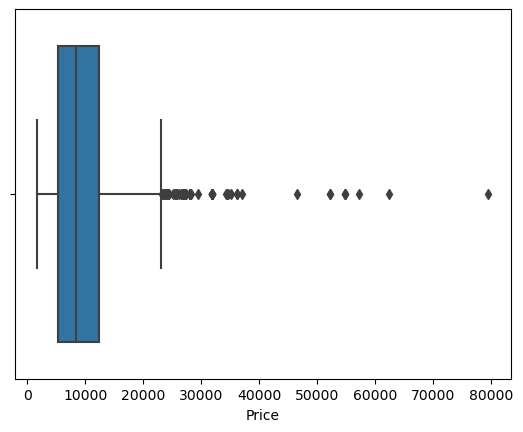

In [9]:
sns.boxplot(data['Price'])
plt.show()

We see individual points from 50000-80000. However without more business context we cannot say if these actually are outliers. Maybe customer purchased a last minute top-range business class ticket on Christmas Day? More data on this particular flight would be needed.

In [10]:
data.loc[train_data['Price'].idxmax()]

Airline            Jet Airways Business
Date_of_Journey              01/03/2019
Source                         Banglore
Destination                   New Delhi
Route                   BLR → BOM → DEL
Dep_Time                          05:45
Arrival_Time                      11:25
Duration                         5h 40m
Total_Stops                      1 stop
Additional_Info          Business class
Price                           79512.0
Name: 2924, dtype: object

Above results represent the most expensive flights in the training data. We see that the flight wasn't even that long but it was a business class flight.

# Exploratory data analysis

1. Most preferred airline

Bar chart showing most preferred Airlines

In [11]:
data['Airline'].value_counts().index

Index(['Jet Airways', 'IndiGo', 'Air India', 'Multiple carriers', 'SpiceJet',
       'Vistara', 'Air Asia', 'GoAir', 'Multiple carriers Premium economy',
       'Jet Airways Business', 'Vistara Premium economy', 'Trujet'],
      dtype='object')

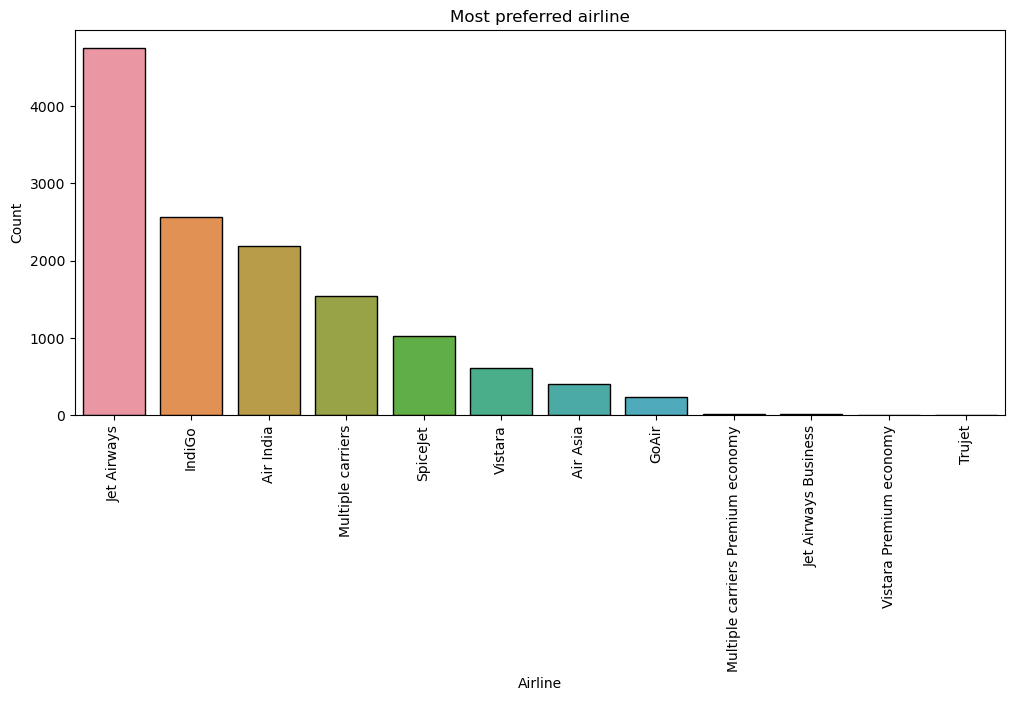

In [12]:
plt.figure(figsize=(12,5))
sns.countplot(data['Airline'], order=data['Airline'].value_counts().index, ec='black')
plt.title('Most preferred airline')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

Insights
 - Most preferred Airline is "Jet Airways" which sold the most tickets followed by Indigo

2. What is the most expensive airline? 

In [13]:
price_grouped = data.groupby('Airline')['Price'].max().sort_values(ascending= False)
price_grouped_df = price_grouped.to_frame()

In [14]:
price_grouped_df

,Price
Airline,
Jet Airways Business,79512.0
Jet Airways,54826.0
Multiple carriers,36983.0
Air India,31945.0
SpiceJet,23267.0
GoAir,22794.0
IndiGo,22153.0
Vistara,21730.0
Multiple carriers Premium economy,14629.0


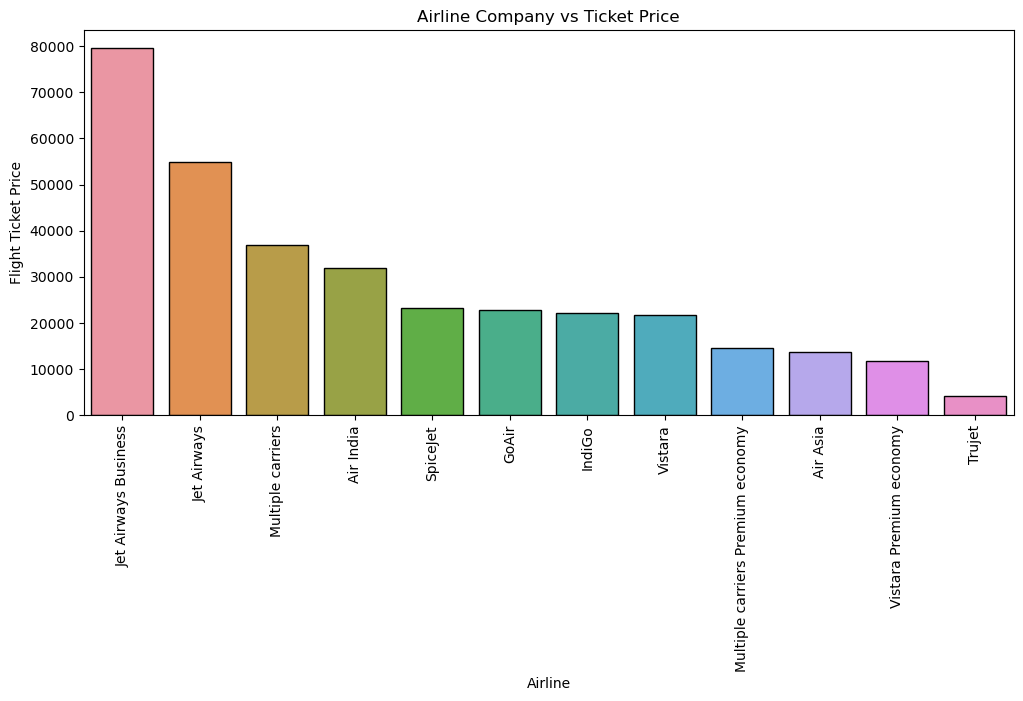

In [15]:
plt.figure(figsize= (12,5))
sns.barplot(x=price_grouped_df.index, y=price_grouped_df['Price'], ec='black')
plt.title('Airline Company vs Ticket Price')
plt.xticks(rotation=90)
plt.ylabel('Flight Ticket Price')
plt.show()

Above graph shows that Jet Airways Business sold the most expensive ticket. Comparing maxmimum price is subjective as it does not take into account the class person travelled and the distance. We can't take duration into account as it not necesserily mean flight time as it also includes layover.

3. On which day of the week were the flights the most expensive?

In [16]:
days_df = data[['Airline', 'Price', 'Date_of_Journey']].copy()
days_df.head()

,Airline,Price,Date_of_Journey
0,IndiGo,3897.0,24/03/2019
1,Air India,7662.0,1/05/2019
2,Jet Airways,13882.0,9/06/2019
3,IndiGo,6218.0,12/05/2019
4,IndiGo,13302.0,01/03/2019


In [17]:
days_df['Date_of_Journey'] = pd.to_datetime(days_df['Date_of_Journey'], format= '%d/%M/%Y')
days_df['Weekday'] = days_df['Date_of_Journey'].dt.day_name()

In [18]:
days_df.head()

,Airline,Price,Date_of_Journey,Weekday
0,IndiGo,3897.0,2019-01-24 00:03:00,Thursday
1,Air India,7662.0,2019-01-01 00:05:00,Tuesday
2,Jet Airways,13882.0,2019-01-09 00:06:00,Wednesday
3,IndiGo,6218.0,2019-01-12 00:05:00,Saturday
4,IndiGo,13302.0,2019-01-01 00:03:00,Tuesday


In [19]:
grouped_day = days_df.groupby('Weekday')['Price'].max().sort_values(ascending=False)
grouped_day_df = grouped_day.to_frame()

In [20]:
grouped_day_df

,Price
Weekday,
Tuesday,79512.0
Friday,54826.0
Sunday,52285.0
Thursday,46490.0
Wednesday,34608.0
Saturday,23843.0
Monday,16655.0


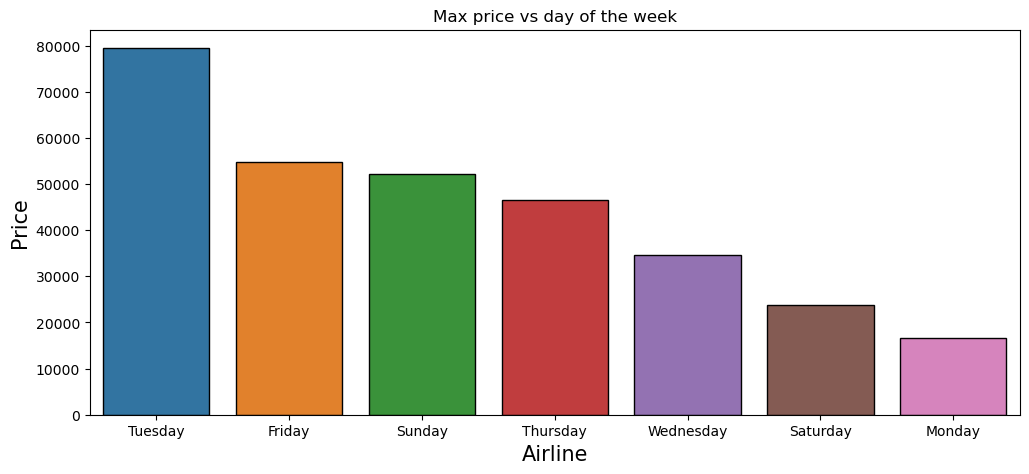

In [21]:
plt.figure(figsize=(12,5))
sns.barplot(x = grouped_day_df.index, y = grouped_day_df['Price'], ec='black')
plt.title('Max price vs day of the week')
plt.xlabel('Airline', size=15)
plt.ylabel('Price', size=15)
plt.show()

Caveat in the above graph is that it shows a single max value. If e.g there was a bank holiday on this particular Tuesday that would increase the flight ticket price. Therefore, assuming that tickets are the most expensive on Tuesdays would be incorrect.

Let's have a look at the mean price instead.

In [22]:
grouped_day_mean = days_df.groupby('Weekday')['Price'].mean().sort_values(ascending=False)
grouped_day_df_mean = grouped_day_mean.to_frame()
grouped_day_df_mean 

,Price
Weekday,
Wednesday,9551.474395
Sunday,9369.226634
Tuesday,9362.485187
Saturday,9110.774295
Thursday,8685.800000
Friday,8671.573317
Monday,8351.760576


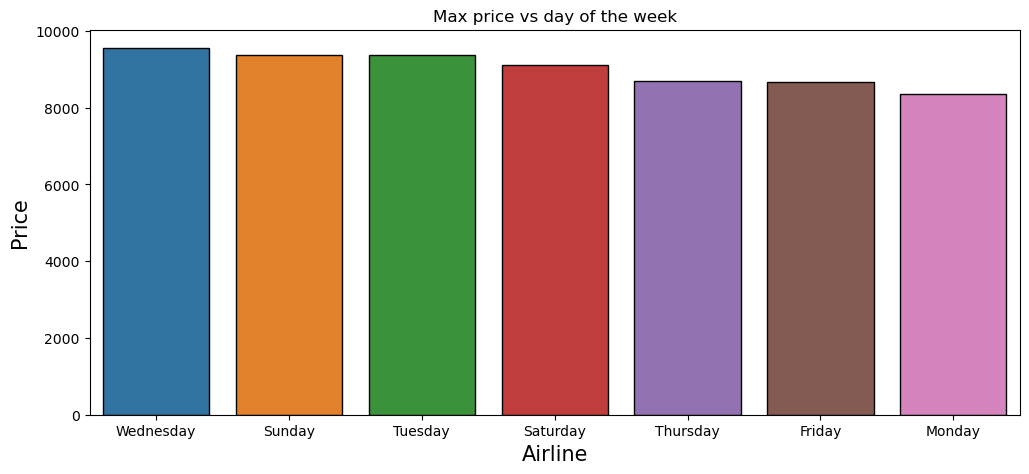

In [23]:
plt.figure(figsize=(12,5))
sns.barplot(x = grouped_day_df_mean.index, y = grouped_day_df_mean['Price'], ec='black')
plt.title('Max price vs day of the week')
plt.xlabel('Airline', size=15)
plt.ylabel('Price', size=15)
plt.show()

An important part in the ticket price plays the time of year. Usually people travel more during summer months in Europe and around Christmas time in December. Unfortunately, one of the limitations of this dataset is that it only provides data for January.

In [24]:
days_df['Date_of_Journey'].max(), days_df['Date_of_Journey'].min()

(Timestamp('2019-01-27 00:06:00'), Timestamp('2019-01-01 00:03:00'))

# Feature Engineering

Which variables are relevant for training our model?

First we need to prepare the dataset.

Extracting day, month, year

In [25]:
data['Date'] = data['Date_of_Journey'].str.split('/').str[0].astype(int)
data['Month'] = data['Date_of_Journey'].str.split('/').str[1].astype(int)
data['Year'] = data['Date_of_Journey'].str.split('/').str[2].astype(int)

In [26]:
data = data.drop('Date_of_Journey', axis=1)

We can drop year as it's the same for all rows

In [27]:
data['Year'].value_counts()

2019    13354
Name: Year, dtype: int64

In [28]:
data = data.drop('Year', axis=1)

Total_Stops column has strings. We can change it to numerical variable.

In [29]:
data['Total_Stops'] = data['Total_Stops'].str.split(' ').str[0]
data['Total_Stops'] = data['Total_Stops'].replace('non-stop', 0)

Additional_Info column.  More than 70% of them have no information therefore we will drop it.

We will also drop Route column as the same information has been accounted for in Total_Stops columns, so that we avoid correlation.

In [30]:
data['Additional_Info'].value_counts()

No info                         10493
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
1 Short layover                     1
Red-eye flight                      1
2 Long layover                      1
Name: Additional_Info, dtype: int64

In [31]:
data = data.drop(['Additional_Info', 'Route'], axis=1) 

In [32]:
data['Arrival_Time'] = data['Arrival_Time'].str.split(' ').str[0]

Find the duration in minutes to remove 'h' and 'm':

In [33]:
data['Duration_hr'] = data['Duration'].str.split('h').str[0]

How many flights were below 1h?

In [34]:
data['Duration_hr'].str.contains('m').sum()

2

In [35]:
data[data['Duration_hr'].str.contains('m')]

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Date,Month,Duration_hr
6474,Air India,Mumbai,Hyderabad,16:50,16:55,5m,2,17327.0,6,3,5m
2660,Air India,Mumbai,Hyderabad,16:50,16:55,5m,2,NaN,12,3,5m


In [36]:
data['Duration_hr'] = data['Duration_hr'].replace('5m', 0)

In [37]:
data['Duration_min'] = data['Duration'].str.split(' ').str[1].str.split('m').str[0]
data['Duration_min'].fillna('0', inplace=True)

In [38]:
data['Duration'] = (data['Duration_hr'].astype(int))* 60 + data['Duration_min'].astype(int)
data = data.drop(['Duration_hr', 'Duration_min'], axis=1)

In [39]:
data.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Date,Month
0,IndiGo,Banglore,New Delhi,22:20,01:10,170,0,3897.0,24,3
1,Air India,Kolkata,Banglore,05:50,13:15,445,2,7662.0,1,5
2,Jet Airways,Delhi,Cochin,09:25,04:25,1140,2,13882.0,9,6
3,IndiGo,Kolkata,Banglore,18:05,23:30,325,1,6218.0,12,5
4,IndiGo,Banglore,New Delhi,16:50,21:35,285,1,13302.0,1,3


Extracting hours and minutes from departure and arrival time.

In [40]:
data['Dep_Hour'] = data['Dep_Time'].str.split(':').str[0].astype(int)
data['Dep_Min'] = data['Dep_Time'].str.split(':').str[1].astype(int)

data['Arrival_Hour'] = data['Arrival_Time'].str.split(':').str[0].astype(int)
data['Arrival_Min'] = data['Arrival_Time'].str.split(':').str[1].astype(int)

In [41]:
data = data.drop(['Dep_Time', 'Arrival_Time'], axis=1)

Checking for null values

In [42]:
data.isnull().sum()

Airline            0
Source             0
Destination        0
Duration           0
Total_Stops        1
Price           2671
Date               0
Month              0
Dep_Hour           0
Dep_Min            0
Arrival_Hour       0
Arrival_Min        0
dtype: int64

In [43]:
data[data['Total_Stops'].isnull()]

,Airline,Source,Destination,Duration,Total_Stops,Price,Date,Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
9039,Air India,Delhi,Cochin,1420,NaN,7480.0,6,5,9,45,9,25


Missing value is in train dataset.W

We will input the most frequent value

In [44]:
data['Total_Stops'].value_counts()

1    7056
0    4340
2    1899
3      56
4       2
Name: Total_Stops, dtype: int64

In [45]:
data['Total_Stops'] = data['Total_Stops'].fillna('1')
data['Total_Stops'] = data['Total_Stops'].astype(int)

In [46]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Date,Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
0,IndiGo,Banglore,New Delhi,170,0,3897.0,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,445,2,7662.0,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,1140,2,13882.0,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,325,1,6218.0,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,285,1,13302.0,1,3,16,50,21,35


# Encoding catogerical variables

Features with Categorical data:
 - Airline
 - Source
 - Destination
 
We will apply Apply Label Encoder to these features.

In [47]:
le = LabelEncoder()
for i in ['Airline', 'Source', 'Destination']:
    data[i] = le.fit_transform(data[i])

In [48]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Date,Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
0,3,0,5,170,0,3897.0,24,3,22,20,1,10
1,1,3,0,445,2,7662.0,1,5,5,50,13,15
2,4,2,1,1140,2,13882.0,9,6,9,25,4,25
3,3,3,0,325,1,6218.0,12,5,18,5,23,30
4,3,0,5,285,1,13302.0,1,3,16,50,21,35


# Feature correlation

Let's look at the heatmap to see which variables might be correlated.

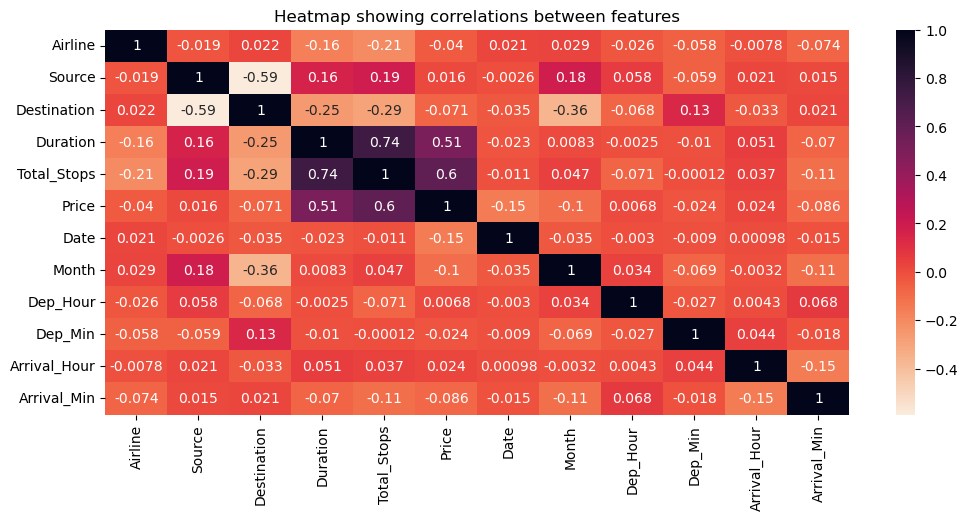

In [49]:
plt.figure(figsize=(12,5))
sns.heatmap(data.corr(), annot=True, cmap="rocket_r")
plt.title('Heatmap showing correlations between features')
plt.show()

We can notice high correlation between:
 - Price & Duration
 - Price & Total Stops
 - Duration & Total Stops

# Train Test Split

In [50]:
train_df=data[0:10683]
test_df=data[10683:]

In [51]:
X = train_df.drop('Price', axis=1)
y = train_df['Price']

In [52]:
y.isnull().sum()

0

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

# Models

In [54]:
def train_algo(algorithm: str) -> str:
    """
    This function takes algorithm given, fits and predicts data and returns r2 score, MAE and MSE.
    
    Parameters:
    algorithm: regressor algorithm used for prediction
    
    Returns:
    str: r2 score, MAE, MSE
    """
    print('Prediction for ' + str(algorithm))
    model = algorithm.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print('r2 score is: ' + str(r2))
    print('MAE:',(mean_absolute_error(y_test,y_pred)))
    print('MSE:',(mean_squared_error(y_test,y_pred)))
    return r2

K-nearest Neigbours Regressor

In [55]:
knn = train_algo(KNeighborsRegressor())

Prediction for KNeighborsRegressor()
r2 score is: 0.5726763449769507
MAE: 1791.6727817296892
MSE: 8111467.312826656


Decision Tree Regressor

In [56]:
dt = train_algo(DecisionTreeRegressor())

Prediction for DecisionTreeRegressor()
r2 score is: 0.6772267122820574
MAE: 1325.8013790091102
MSE: 6126889.86907702


Random Forest Regressor

In [57]:
rf = train_algo(RandomForestRegressor())

Prediction for RandomForestRegressor()
r2 score is: 0.8072401575680536
MAE: 1141.368258312936
MSE: 3658971.701503427


Presenting accuracies of the models in a dataframe

In [58]:
score_df = pd.DataFrame({'Model': ['K-Nearest Naighbour', 'DecisionTreeRegressor', 'RandomForestRegressor'], 
                         'Accuracy' : [knn*100, dt*100, rf*100]})
score_df

,Model,Accuracy
0,K-Nearest Naighbour,57.267634
1,DecisionTreeRegressor,67.722671
2,RandomForestRegressor,80.724016


Random Forest seems to have the highest R2 score. Let's try hypterparameter tuning for this model.

In [59]:
random_search = {'n_estimators' : [120, 150, 180, 190, 195, 200, 220, 250],
                 'max_features':['auto','sqrt'],
                 'max_depth':[5,10,15,20],
                 'min_samples_split' : [2, 5, 10, 15, 100],
                 'min_samples_leaf' : [1, 2, 5, 10]}
rf_regressor = RandomForestRegressor()
rf_model = RandomizedSearchCV(estimator = rf_regressor, param_distributions = random_search, cv=3, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [120, 150, 180, 190,
                                                         195, 200, 220, 250]})

In [60]:
rf_model.best_params_

{'n_estimators': 220,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15}

In [61]:
pred = rf_model.predict(X_test)
r2_score(y_test, pred)

0.8302123267080054

In [62]:
print('r2_score:',r2_score(y_test,pred))
print('MAE:', mean_absolute_error(y_test, pred))
print('MSE:', mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))

r2_score: 0.8302123267080054
MAE: 1091.0294366797252
MSE: 3222913.4658005754
RMSE: 1795.2474664515128


For Random Forest Regressor,

- Before hyperparameter tuning, R2 score = 80 %
- After hyperparameter tuning, R2 score = 83 %
- The value of MAE drops as well, indicating that we are successful in tunning our model.

# Conclusions

We have used random forest regressor for training the model and improved its accuracy by doing hyperparameter tuning.
As a result, we have trained our Random Forest Regression model, to forecast fares of flight tickets, with an R2 score of 83 %.